# Import Necessary Libraries

In [17]:
import os
from PIL import Image
import itertools

import cv2
import numpy as np 
import pandas as pd 
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout,BatchNormalization

import warnings
warnings.filterwarnings('ignore')

print('Modules Successfully Loaded')

Modules Successfully Loaded


# Make DataFrame

In [18]:
data_dir ="/kaggle/input/brain-tumor-mri-images-44c"
paths = []
labels = []
folds = os.listdir(data_dir)
for fold in folds :
    condition_path = os.path.join(data_dir,fold)
    all_pic = os.listdir(condition_path)
    for each_pic in all_pic:
        each_pic_path = os.path.join(condition_path,each_pic)
        paths.append(each_pic_path)
        labels.append(fold.split(' ')[0])
        
pseries = pd.Series(paths, name='Picture Path')
lseries = pd.Series(labels, name='Label')

df = pd.concat([pseries, lseries], axis =1)
df

,Picture Path,Label
0,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma
1,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma
2,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma
3,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma
4,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma
...,...,...
4474,/kaggle/input/brain-tumor-mri-images-44c/Germi...,Germinoma
4475,/kaggle/input/brain-tumor-mri-images-44c/Germi...,Germinoma
4476,/kaggle/input/brain-tumor-mri-images-44c/Germi...,Germinoma
4477,/kaggle/input/brain-tumor-mri-images-44c/Germi...,Germinoma


## Splitting The Data

In [19]:
train_df, test_df = train_test_split(df,test_size= 0.3,shuffle=True,random_state=42,stratify= df['Label'])


In [20]:
train_df

,Picture Path,Label
2197,/kaggle/input/brain-tumor-mri-images-44c/Menin...,Meningioma
372,/kaggle/input/brain-tumor-mri-images-44c/_NORM...,_NORMAL
3964,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma
925,/kaggle/input/brain-tumor-mri-images-44c/Germi...,Germinoma
1895,/kaggle/input/brain-tumor-mri-images-44c/Gliob...,Glioblastoma
...,...,...
697,/kaggle/input/brain-tumor-mri-images-44c/Schwa...,Schwannoma
4292,/kaggle/input/brain-tumor-mri-images-44c/Epend...,Ependimoma
4414,/kaggle/input/brain-tumor-mri-images-44c/Oligo...,Oligodendroglioma
947,/kaggle/input/brain-tumor-mri-images-44c/Germi...,Germinoma


In [21]:
test_df

,Picture Path,Label
2587,/kaggle/input/brain-tumor-mri-images-44c/Carci...,Carcinoma
2819,/kaggle/input/brain-tumor-mri-images-44c/Menin...,Meningioma
1460,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma
2412,/kaggle/input/brain-tumor-mri-images-44c/Menin...,Meningioma
2287,/kaggle/input/brain-tumor-mri-images-44c/Menin...,Meningioma
...,...,...
4010,/kaggle/input/brain-tumor-mri-images-44c/Schwa...,Schwannoma
304,/kaggle/input/brain-tumor-mri-images-44c/_NORM...,_NORMAL
2258,/kaggle/input/brain-tumor-mri-images-44c/Menin...,Meningioma
2224,/kaggle/input/brain-tumor-mri-images-44c/Menin...,Meningioma


## Image Data Generator

In [22]:
batch_size = 32
img_size = (224,224)

gen = ImageDataGenerator()

train_gen = gen.flow_from_dataframe(train_df, x_col='Picture Path', y_col='Label',target_size= img_size, 
                                   class_mode= 'categorical', color_mode='rgb', shuffle = True,
                                   batch_size= batch_size)


test_gen = gen.flow_from_dataframe(test_df, x_col='Picture Path', y_col='Label',target_size= img_size, 
                                   class_mode= 'categorical', color_mode='rgb', shuffle = False,
                                   batch_size= batch_size)

Found 3134 validated image filenames belonging to 15 classes.
Found 1344 validated image filenames belonging to 15 classes.


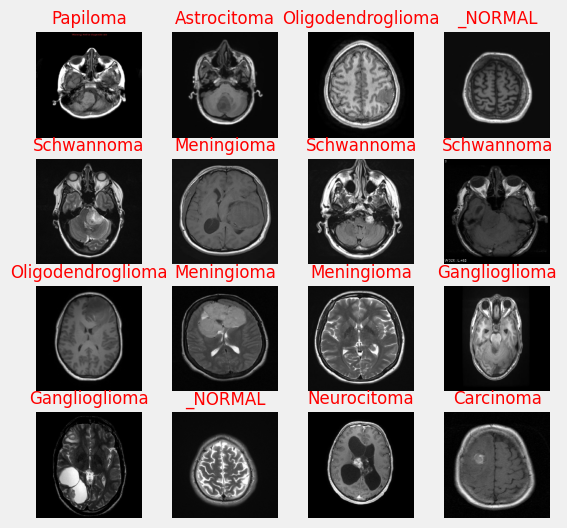

In [23]:
g_dict = train_gen.class_indices
classes= list(g_dict.keys())

images, labels = next(train_gen)

plt.figure(figsize= (6,6))

for i in range (16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index= np.argmax(labels[i]) #[0,0,0,1,0]
    class_name = classes[index]
    plt.title(class_name,c='r', fontsize=12)
    plt.axis('off')
plt.show()

# Create Model Structure

In [24]:
from tensorflow.keras.layers import Dropout

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
model.add(MaxPooling2D())
    
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128,activation = "relu"))
model.add(Dense(64,activation = "relu"))
model.add(Dense(32,activation = "relu"))
model.add(Dense(class_count, activation = "softmax"))

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 28, 28, 64)       

In [25]:
hist= model.fit(train_gen, epochs= 15, verbose= 1, shuffle= False )

Epoch 1/15
98/98 [==============================] - 12s 103ms/step - loss: 45.1953 - accuracy: 0.2112
Epoch 2/15
98/98 [==============================] - 11s 109ms/step - loss: 17.1401 - accuracy: 0.5041
Epoch 3/15
98/98 [==============================] - 10s 105ms/step - loss: 10.3486 - accuracy: 0.6892
Epoch 4/15
98/98 [==============================] - 11s 108ms/step - loss: 7.3055 - accuracy: 0.8204
Epoch 5/15
98/98 [==============================] - 10s 107ms/step - loss: 4.4309 - accuracy: 0.8484
Epoch 6/15
98/98 [==============================] - 10s 104ms/step - loss: 7.5936 - accuracy: 0.9135
Epoch 7/15
98/98 [==============================] - 10s 106ms/step - loss: 2.2523 - accuracy: 0.9292
Epoch 8/15
98/98 [==============================] - 10s 106ms/step - loss: 6.0911 - accuracy: 0.9655
Epoch 9/15
98/98 [==============================] - 11s 113ms/step - loss: 1.9059 - accuracy: 0.9422
Epoch 10/15
98/98 [==============================] - 11s 108ms/step - loss: 2.1006 - acc

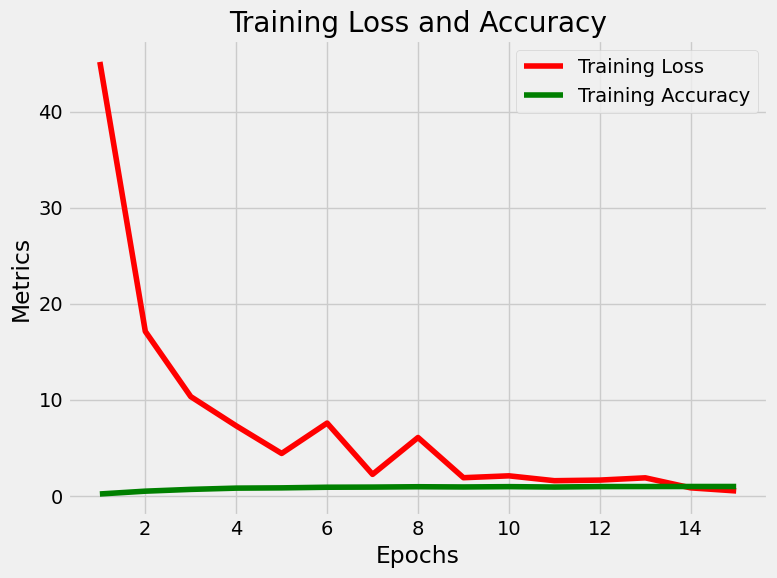

In [31]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']

epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(8, 6))
plt.style.use('fivethirtyeight')

plt.plot(epochs, tr_loss, c='r', label='Training Loss')
plt.plot(epochs, tr_acc, c='g', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.title('Training Loss and Accuracy')
plt.tight_layout()
plt.show()


In [28]:
train_score= model.evaluate(train_gen)
test_score=  model.evaluate(test_gen)

42/42 [==============================] - 5s 112ms/step - loss: 0.3450 - accuracy: 0.9234


In [29]:
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

Train Loss:  0.5997151732444763
Train Accuracy:  0.990427553653717
--------------------
Test Loss:  0.3449520766735077
Test Accuracy:  0.9233630895614624


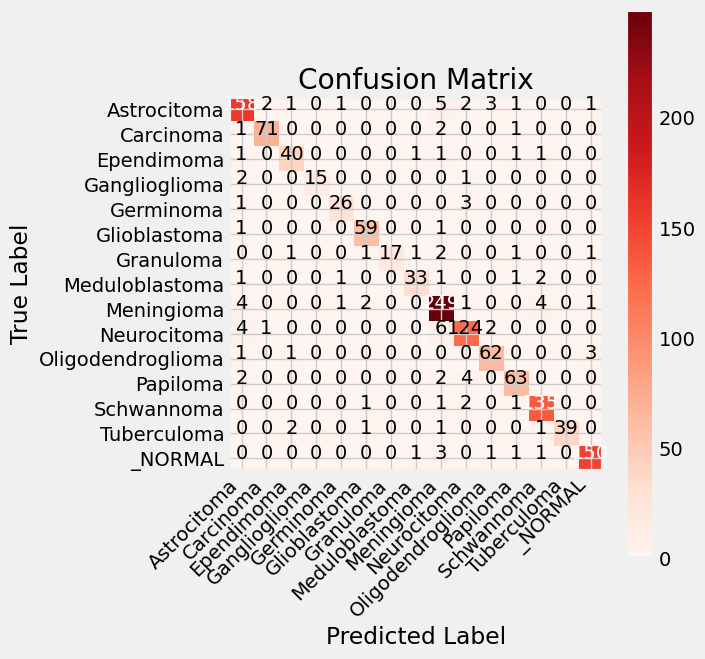

In [30]:
preds = model.predict_generator(test_gen)
y_pred= np.argmax(preds,axis=1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(7, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))

# Manually adjust the x-axis tick labels
plt.xticks(tick_marks, classes, rotation=45, ha='right')

plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
